![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [124]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/world-cities-database/LICENSE.txt
/kaggle/input/world-cities-database/worldcitiespop.csv


In [125]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [126]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [127]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')





# Импорт базы городов

In [128]:
cities_pop = pd.read_csv('/kaggle/input/world-cities-database/worldcitiespop.csv')
cities_pop.info()
cities_pop.head(5)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3173958 entries, 0 to 3173957
Data columns (total 7 columns):
Country       object
City          object
AccentCity    object
Region        object
Population    float64
Latitude      float64
Longitude     float64
dtypes: float64(3), object(4)
memory usage: 169.5+ MB


,Country,City,AccentCity,Region,Population,Latitude,Longitude
0,ad,aixas,Aixàs,6,NaN,42.483333,1.466667
1,ad,aixirivali,Aixirivali,6,NaN,42.466667,1.500000
2,ad,aixirivall,Aixirivall,6,NaN,42.466667,1.500000
3,ad,aixirvall,Aixirvall,6,NaN,42.466667,1.500000
4,ad,aixovall,Aixovall,6,NaN,42.466667,1.483333


In [129]:


cities_pop['Population'].fillna(cities_pop['Population'].mean(), inplace=True) # Заполим пустые средним занчением
cities_pop['Population'] = round(cities_pop['Population'] / 1000) # уменьшим разрядность
population = cities_pop.groupby(['AccentCity'])['Population'].max().to_dict() # создадим словарь



In [130]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [131]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [132]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [133]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [134]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [135]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [136]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [137]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [138]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
3105,id_3105,Vienna,"['Italian', 'Pizza', 'Vegetarian Friendly', 'V...",452.0,$$ - $$$,253.0,"[['It was ok.', 'Good quality sourdough pizza'...",/Restaurant_Review-g190454-d3784431-Reviews-Pi...,d3784431,0,0.0
28925,id_324,Dublin,"['Asian', 'Thai', 'Vegetarian Friendly', 'Vega...",325.0,$$ - $$$,454.0,"[['Family fave', 'Three out of four good.'], [...",/Restaurant_Review-g186605-d1024714-Reviews-Th...,d1024714,1,4.0
1604,id_1604,Paris,['Chinese'],8036.0,NaN,2.0,"[['Yummy new Hunan restaurant!'], ['04/21/2013']]",/Restaurant_Review-g187147-d4103149-Reviews-Ne...,d4103149,0,0.0
3012,id_3012,Warsaw,['American'],554.0,$$ - $$$,13.0,"[['Small, but innovative restaurant in a nice....",/Restaurant_Review-g274856-d12711658-Reviews-K...,d12711658,0,0.0
9030,id_9030,Rome,"['American', 'Mediterranean', 'European', 'Ita...",3993.0,$$$$,40.0,"[['Something special', 'Excellent Food and Ser...",/Restaurant_Review-g187791-d6673382-Reviews-J_...,d6673382,0,0.0


In [139]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [140]:
data.nunique(dropna=False)

Restaurant_id        13094
City                    31
Cuisine Style        10732
Ranking              12975
Price Range              4
Number of Reviews     1574
Reviews              41858
URL_TA               49963
ID_TA                49963
sample                   2
Rating                  10
dtype: int64

Какие признаки можно считать категориальными?

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

> Для некоторых алгоритмов МЛ даже для не категориальных признаков можно применить One-Hot Encoding, и это может улучшить качество модели. Пробуйте разные подходы к кодированию признака - никто не знает заранее, что может взлететь.

### Обработать другие признаки вы должны самостоятельно!
Для обработки других признаков вам возможно придется даже написать свою функцию, а может даже и не одну, но в этом и есть ваша практика в этом модуле!     
Следуя подсказкам в модуле вы сможете более подробно узнать, как сделать эти приобразования.

In [141]:
# выводим информацию о наличии пропуска в отдельный призак  

df = df_train
df.rename(columns={'Cuisine Style': 'Cuisine_Style', 'Price Range': 'Price_Range', 'Number of Reviews': 'Number_of_Reviews'}, inplace=True)
df['Number_of_Reviews_isNAN'] = pd.isna(df.Number_of_Reviews).astype('uint8')
df['Cuisine_Style_isNAN'] = pd.isna(df.Cuisine_Style).astype('uint8')
df['Price_Range_isNAN'] = pd.isna(df.Price_Range).astype('uint8')
df['Reviewse_isNAN'] = pd.isna(df.Reviews).astype('uint8')
df['Number_of_Reviews_isNAN'] = pd.isna(df['Number_of_Reviews']).astype('uint8')

# заполняем пропуски
df.Cuisine_Style.fillna('other', inplace=True)
df.Number_of_Reviews.fillna(round(df.Number_of_Reviews.mean()), inplace=True)
df.Price_Range.fillna('$$ - $$$', inplace=True)
df.Reviews.fillna('[[], []]', inplace=True)


In [142]:
def prepare_reviews(s):
    ''' преобразование отзывов в список '''
    l = s[2:-2].replace('], [','|').split('|')
    v0 = l[0].split(',')
    v1 = l[1].split(',')

    return [v0, v1] 

# Cuisine Style
# сделаем список
df.Cuisine_Style = df['Cuisine_Style'].astype(str).str[2:-2].str.split(',')

# Price Range
df.Price_Range = df.Price_Range.apply(lambda x: len(str(x)))

# Преобразование отзвово в список
df.Reviews = df.Reviews.map(lambda x: prepare_reviews(str(x)))



In [143]:
df.Cuisine_Style.head(3)

0              [European',  'French',  'International]
1                                                  [h]
2    [Japanese',  'Sushi',  'Asian',  'Grill',  'Ve...
Name: Cuisine_Style, dtype: object

# Генерация новых фичей

In [144]:
# Restaurant_id  надо сделать признак сетевой network т.к. под одним ид бывает несколько ресторанов

tmp_dict = df.Restaurant_id.value_counts().to_dict()
df['Network_size'] = df['Restaurant_id'].map(tmp_dict) # размер сети
df['Network'] = df['Network_size'].apply(lambda x: 0 if (x == 1) else 1) # признак сетевой



# добавляем поле население
df['Population'] = df.apply(lambda row: population[row['City']], axis=1)        

# City: Город
tmp_dict = df['City'].value_counts().to_dict() # словарь ресторанов в городе
df['Restaurant_num'] = df['City'].map(tmp_dict)  # количество ресторанов в городе
df['Restaurant_on_people'] = df.Restaurant_num / df.Population # ресторанов на человека


# Cuisine Style
df['Cuisine_Style_Num'] = df['Cuisine_Style'].str.len() # количесво кухонь

# Ranking: Ранг ресторана относительно других ресторанов в этом городе
df['Ranking_city'] = df.Ranking / df.City.map(df.groupby(['City'])['Ranking'].max()) # ранг относительно максимального в городе
df['Ranking_pop'] = df.Ranking_city / df.Population # ранг относительно населения
df['Number_of_Reviews_pop'] = df.Number_of_Reviews / df.Population # отзывы относително населения

# Посмотрим распределение признаков

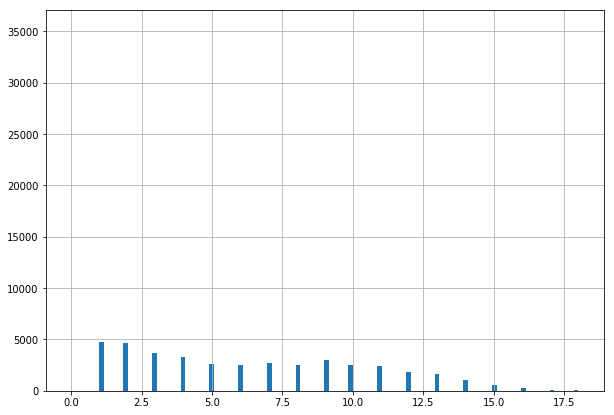

In [145]:
plt.rcParams['figure.figsize'] = (10, 7)
df['Network_size'].hist(bins=100)
df['Network'].hist(bins=100)

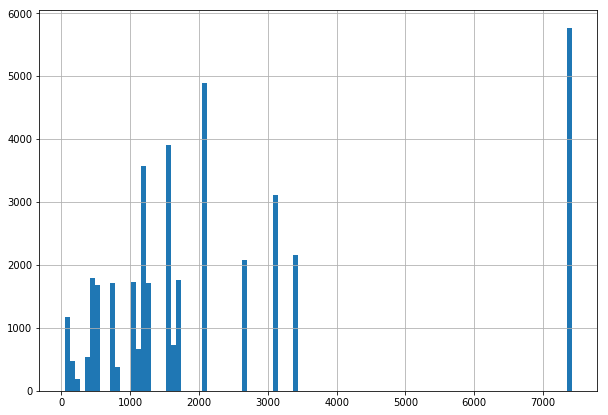

In [146]:
plt.rcParams['figure.figsize'] = (10, 7)
df['Population'].hist(bins=100)


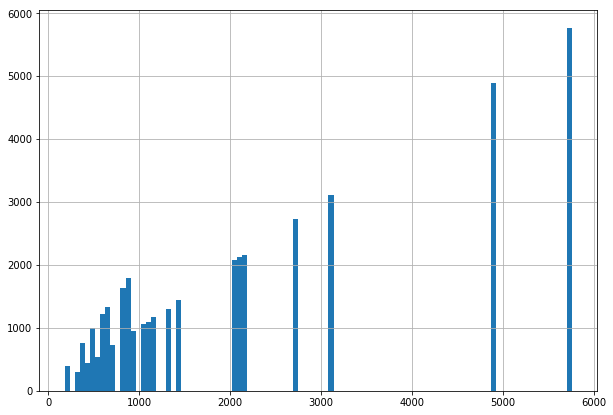

In [147]:
df['Restaurant_num'].hist(bins=100)

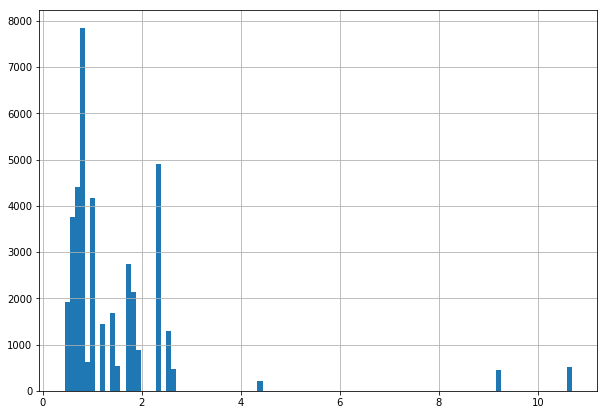

In [148]:
df['Restaurant_on_people'].hist(bins=100)

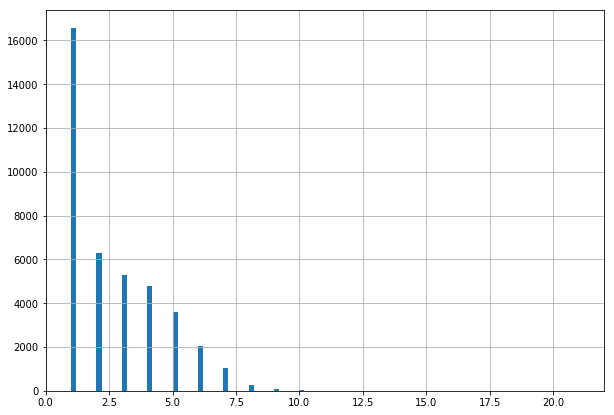

In [149]:
df['Cuisine_Style_Num'].hist(bins=100)

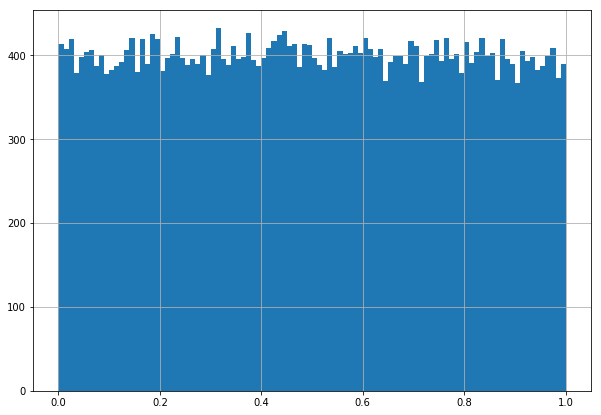

In [150]:
df['Ranking_city'].hist(bins=100)

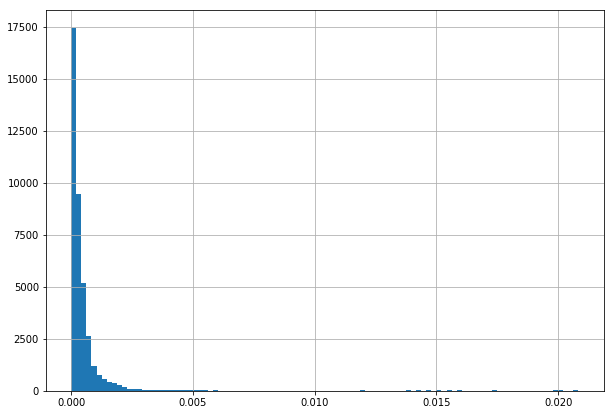

In [151]:
df['Ranking_pop'].hist(bins=100)

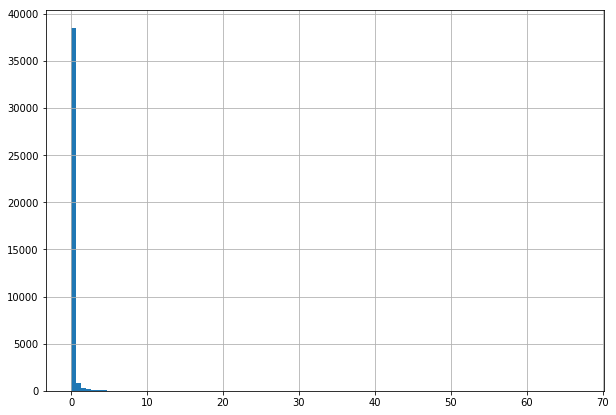

In [152]:
df['Number_of_Reviews_pop'].hist(bins=100)

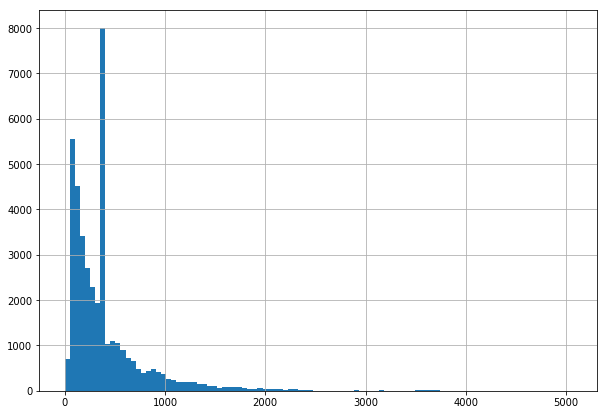

In [153]:
# Reviews: 2 последних отзыва и даты этих отзывов
df['Reviews_Dates'] = df.Reviews.apply(lambda x: x[1])
df['Reviews_Date1'] = df.Reviews_Dates.apply(lambda x: x[0])
df['Reviews_Date2'] = df.Reviews_Dates.apply(lambda x: x[-1])
df['Reviews_Date1'] = pd.to_datetime(df['Reviews_Date1'], errors='coerce')
df['Reviews_Date2'] = pd.to_datetime(df['Reviews_Date2'], errors='coerce')
dmax = df.Reviews_Date2.max()
dmin = df.Reviews_Date1.min()
df['Reviews_Days_Delta_Min'] = (dmax - df.Reviews_Date2).dt.days
df['Reviews_Days_Delta_Min'].fillna(0)
df['Reviews_Days_Delta_Max'] = (dmax - df.Reviews_Date1).dt.days
df.Reviews_Days_Delta_Max.fillna(df.Reviews_Days_Delta_Max.mean(), inplace=True)
df.Reviews_Days_Delta_Min.fillna(df.Reviews_Days_Delta_Min.mean(), inplace=True)
df['Reviews_Days_Delta'] = df.Reviews_Days_Delta_Max - df.Reviews_Days_Delta_Min
df.drop(['Reviews_Date1', 'Reviews_Date2'], axis = 1, inplace=True)
df['Reviews_Days_Delta_Min'].hist(bins=100)


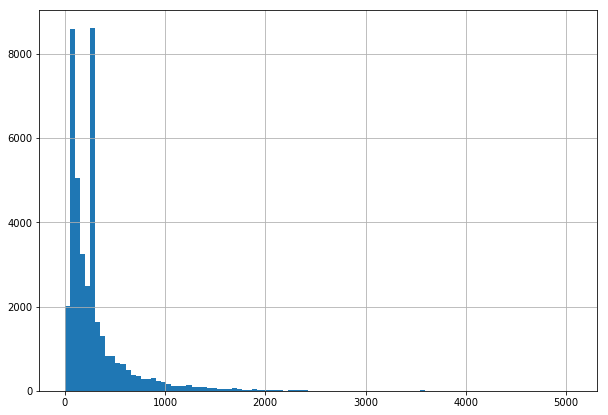

In [154]:
df['Reviews_Days_Delta_Max'].hist(bins=100)


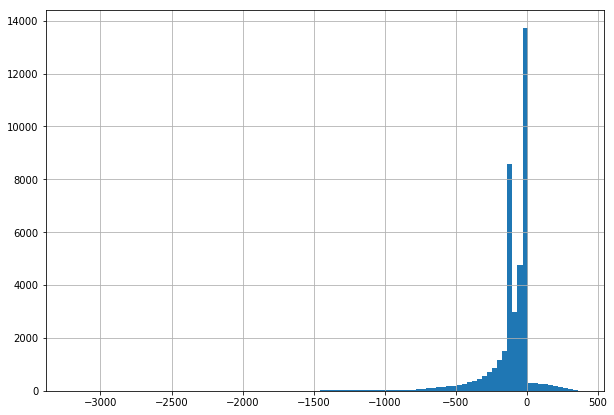

In [155]:

df['Reviews_Days_Delta'].hist(bins=100)


In [156]:
# dummy переменные
df = pd.get_dummies(df, columns=[ 'City',], dummy_na=True)
df['Price_Range_num'] = df.Price_Range
df = pd.get_dummies(df, columns=[ 'Price_Range'], dummy_na=False)


![](https://cs10.pikabu.ru/post_img/2018/09/06/11/1536261023140110012.jpg)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

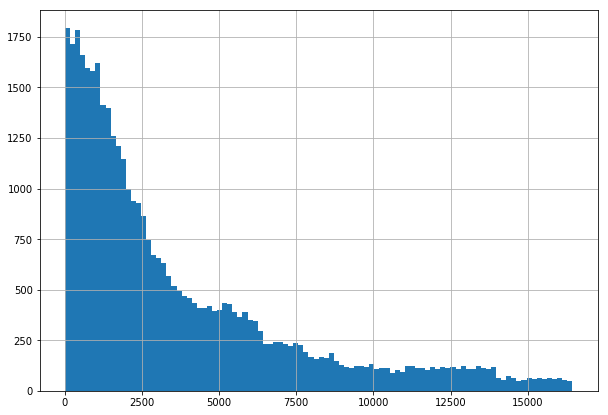

In [157]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

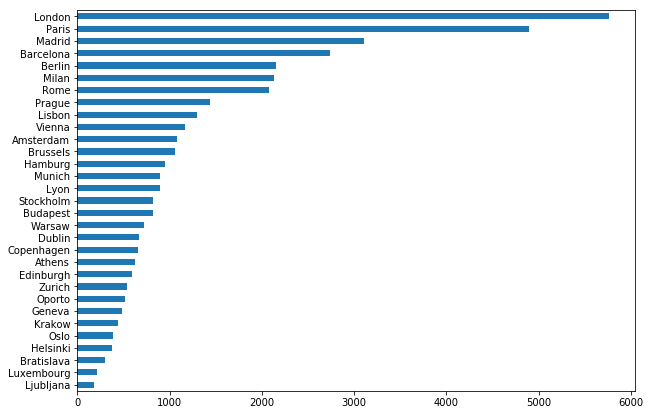

In [158]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

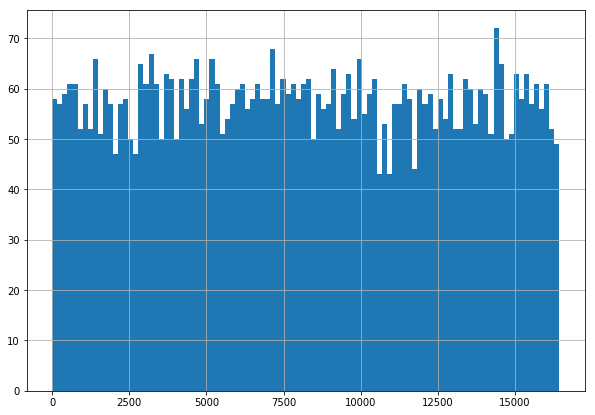

In [159]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

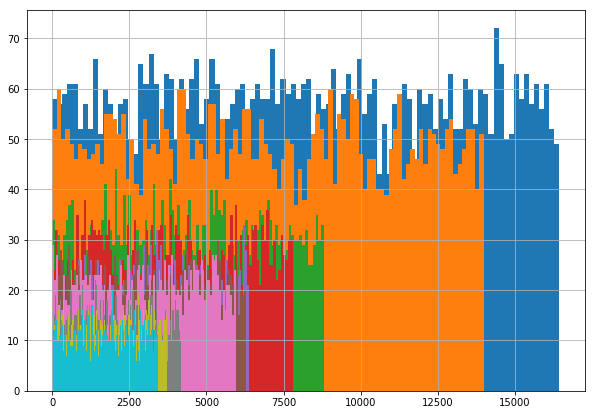

In [160]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

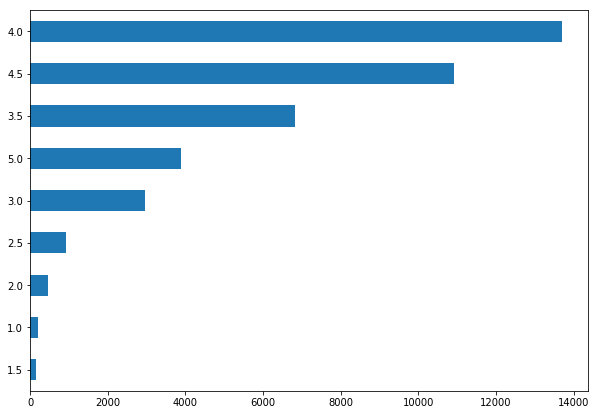

In [161]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

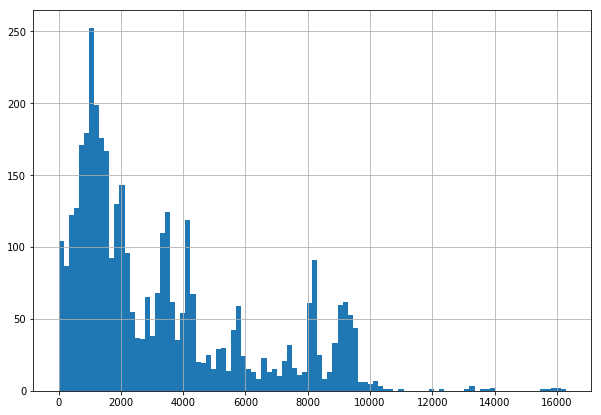

In [162]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

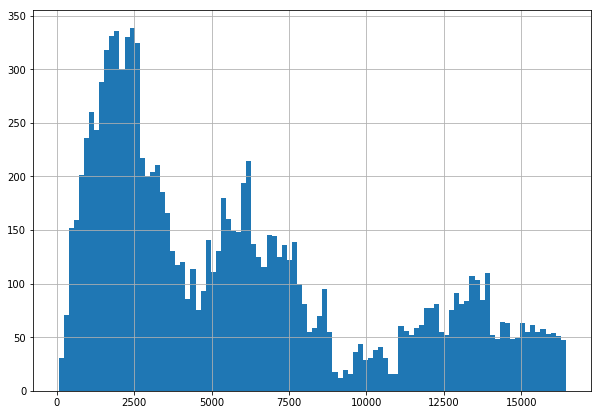

In [163]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

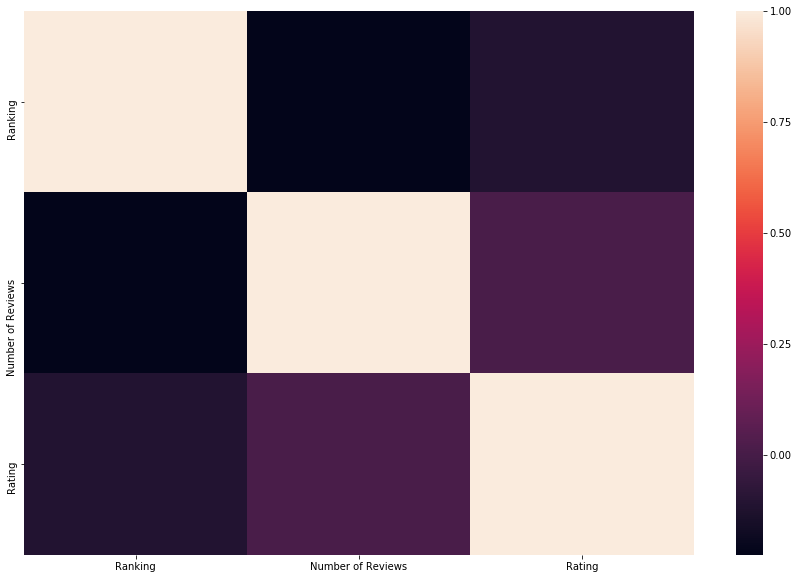

In [164]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [165]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()
cities_pop = pd.read_csv('/kaggle/input/world-cities-database/worldcitiespop.csv')
cities_pop['Population'].fillna(cities_pop['Population'].mean(), inplace=True) # Заполим пустые средним занчением
cities_pop['Population'] = round(cities_pop['Population'] / 1000) # уменьшим разрядность
cities_pop.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3173958 entries, 0 to 3173957
Data columns (total 7 columns):
Country       object
City          object
AccentCity    object
Region        object
Population    float64
Latitude      float64
Longitude     float64
dtypes: float64(3), object(4)
memory usage: 169.5+ MB


In [166]:
import pandas as pd
import numpy as np
import re
import datetime
import time

class Preproc():

    def __init__(self, df):
        # df = df.copy(df)
        df = self.prepare(df)
        df = self.fill_nan(df)
        df = self.encoding(df)
        df = self.make_feuture(df)
        df = self.make_dammies(df)
        df = self.clean(df)
        self.df = df

    def prepare(self, df):
        # ################### 1. Предобработка ############################################################## 
        

        # переименование колонок для удобства
        df.rename(
            columns={'Cuisine Style': 'Cuisine_Style', 'Price Range': 'Price_Range', 'Number of Reviews': 'Number_of_Reviews'}, inplace=True)

        return df
    
    
    def fill_nan(self, df):
        # ################### 2. NAN ############################################################## 
        # Параметры на основе пропусков
        df['Number_of_Reviews_isNAN'] = pd.isna(df.Number_of_Reviews).astype('uint8')
        df['Cuisine_Style_isNAN'] = pd.isna(df.Cuisine_Style).astype('uint8')
        df['Price_Range_isNAN'] = pd.isna(df.Price_Range).astype('uint8')
        df['Reviewse_isNAN'] = pd.isna(df.Reviews).astype('uint8')

        # заполняем пропуске
        df.Number_of_Reviews.fillna(round(df.Number_of_Reviews.mean()), inplace=True)
        df.Cuisine_Style.fillna('other', inplace=True)
        df.Price_Range.fillna('$$ - $$$', inplace=True)
        df.Reviews.fillna('[[], []]', inplace=True)
    
        return df

    def prepare_reviews(self, s):
        ''' преобразование отзывов в список '''
        l = s[2:-2].replace('], [','|').split('|')
        v0 = l[0].split(',')
        v1 = l[1].split(',')
        
        return [v0, v1] 

    def encoding(self, df):
        # ################### 3. Encoding ############################################################## 

        # Cuisine Style
        df.Cuisine_Style = df.Cuisine_Style.str[2:-2].str.split(',')

        # Price Range
        df.Price_Range = df.Price_Range.apply(lambda x: len(str(x)))

        # Преобразование отзвово в список
        df.Reviews = df.Reviews.map(lambda x: self.prepare_reviews(str(x)))

        return df
    
    
    def make_feuture(self, df):
        # ################### 4. Feature Engineering ####################################################
        # Restaurant_id  надо сделать признак сетевой network т.к. под одним ид бывает несколько ресторанов

        tmp_dict = df.Restaurant_id.value_counts().to_dict()
        df['Network_size'] = df['Restaurant_id'].map(tmp_dict) # размер сети
        df['Network'] = df['Network_size'].apply(lambda x: 0 if (x == 1) else 1) # признак сетевой



        # добавляем поле население
        df['Population'] = df.apply(lambda row: population[row['City']], axis=1)        

        # City: Город
        tmp_dict = df['City'].value_counts().to_dict() # словарь ресторанов в городе
        df['Restaurant_num'] = df['City'].map(tmp_dict)  # количество ресторанов в городе
        df['Restaurant_on_people'] = df.Restaurant_num / df.Population # ресторанов на человека


        # Cuisine Style
        df['Cuisine_Style_Num'] = df['Cuisine_Style'].str.len() # количесво кухонь

        # Ranking: Ранг ресторана относительно других ресторанов в этом городе
        df['Ranking_city'] = df.Ranking / df.City.map(df.groupby(['City'])['Ranking'].max()) # ранг относительно максимального в городе
        df['Ranking_pop'] = df.Ranking_city / df.Population # ранг относительно населения
        df['Number_of_Reviews_pop'] = df.Number_of_Reviews / df.Population # отзывы относително населения    
        
        # Reviews: 2 последних отзыва и даты этих отзывов
        df['Reviews_Dates'] = df.Reviews.apply(lambda x: x[1])
        df['Reviews_Date1'] = df.Reviews_Dates.apply(lambda x: x[0])
        df['Reviews_Date2'] = df.Reviews_Dates.apply(lambda x: x[-1])
        df['Reviews_Date1'] = pd.to_datetime(df['Reviews_Date1'], errors='coerce')
        df['Reviews_Date2'] = pd.to_datetime(df['Reviews_Date2'], errors='coerce')
        dmax = df.Reviews_Date2.max()
        dmin = df.Reviews_Date1.min()
        df['Reviews_Days_Delta_Min'] = (dmax - df.Reviews_Date2).dt.days
        df['Reviews_Days_Delta_Min'].fillna(0)
        df['Reviews_Days_Delta_Max'] = (dmax - df.Reviews_Date1).dt.days
        df.Reviews_Days_Delta_Max.fillna(df.Reviews_Days_Delta_Max.mean(), inplace=True)
        df.Reviews_Days_Delta_Min.fillna(df.Reviews_Days_Delta_Min.mean(), inplace=True)
        df['Reviews_Days_Delta'] = df.Reviews_Days_Delta_Max - df.Reviews_Days_Delta_Min
        df.drop(['Reviews_Date1', 'Reviews_Date2'], axis = 1, inplace=True)
        
        return df

    def make_dammies(self, df):
        df = pd.get_dummies(df, columns=[ 'City',], dummy_na=True)
        df['Price_Range_num'] = df.Price_Range
        df = pd.get_dummies(df, columns=[ 'Price_Range'], dummy_na=False)

        return df

    
    def clean(self, df):
        # ################### 5. Clean #################################################### 
        # убираем не нужные для модели признаки
        df.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)

        # убираем признаки которые еще не успели обработать, 
        # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
        object_columns = [s for s in df.columns if df[s].dtypes == 'object' or df[s].dtypes == 'timedelta64' or df[s].dtypes == 'datetime64']
        df.drop(object_columns, axis = 1, inplace=True)

        return df
    
    def get_data(self):
        return self.df



>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [167]:
preproc = Preproc(data)
df_preproc = preproc.get_data()
df_preproc.sample(10)

,Ranking,Number_of_Reviews,sample,Rating,Number_of_Reviews_isNAN,Cuisine_Style_isNAN,Price_Range_isNAN,Reviewse_isNAN,Network_size,Network,...,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,Price_Range_num,Price_Range_1,Price_Range_4,Price_Range_8
28817,13002.0,24.0,1,4.0,0,1,1,0,2,1,...,0,0,0,0,0,0,8,0,0,1
44750,275.0,7.0,1,4.5,0,0,0,0,14,1,...,0,0,0,0,0,0,8,0,0,1
1748,2029.0,114.0,0,0.0,0,0,0,0,8,1,...,0,0,0,0,0,0,8,0,0,1
18296,1233.0,38.0,1,4.5,0,0,0,0,11,1,...,0,0,0,0,0,0,8,0,0,1
8802,2824.0,13.0,0,0.0,0,1,1,0,2,1,...,0,0,0,0,0,0,8,0,0,1
26566,5075.0,20.0,1,3.5,0,0,0,0,3,1,...,1,0,0,0,0,0,1,1,0,0
48808,455.0,125.0,1,4.5,0,0,0,0,11,1,...,0,0,0,0,0,0,8,0,0,1
44413,7413.0,4.0,1,4.0,0,1,1,0,3,1,...,0,0,0,0,0,0,8,0,0,1
14135,2196.0,192.0,1,4.0,0,0,0,0,7,1,...,0,0,0,0,0,0,8,0,0,1
28030,2072.0,60.0,1,4.0,0,0,0,0,10,1,...,0,0,0,0,0,0,8,0,0,1


In [168]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 56 columns):
Ranking                    50000 non-null float64
Number_of_Reviews          50000 non-null float64
sample                     50000 non-null int64
Rating                     50000 non-null float64
Number_of_Reviews_isNAN    50000 non-null uint8
Cuisine_Style_isNAN        50000 non-null uint8
Price_Range_isNAN          50000 non-null uint8
Reviewse_isNAN             50000 non-null uint8
Network_size               50000 non-null int64
Network                    50000 non-null int64
Population                 50000 non-null float64
Restaurant_num             50000 non-null int64
Restaurant_on_people       50000 non-null float64
Cuisine_Style_Num          50000 non-null int64
Ranking_city               50000 non-null float64
Ranking_pop                50000 non-null float64
Number_of_Reviews_pop      50000 non-null float64
Reviews_Days_Delta_Min     50000 non-null float64
Reviews_D

In [169]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [170]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [171]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 55), (40000, 55), (40000, 54), (32000, 54), (8000, 54))

# Model 
Сам ML

In [172]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [173]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [174]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [175]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1994375


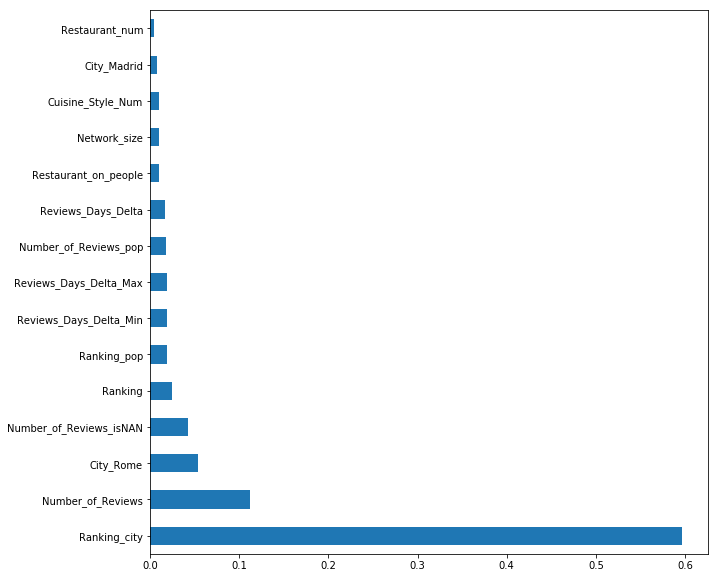

In [176]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [177]:
test_data.sample(10)

,Ranking,Number_of_Reviews,Rating,Number_of_Reviews_isNAN,Cuisine_Style_isNAN,Price_Range_isNAN,Reviewse_isNAN,Network_size,Network,Population,...,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,Price_Range_num,Price_Range_1,Price_Range_4,Price_Range_8
7066,4295.0,14.0,0.0,0,0,0,0,2,1,1157.0,...,0,0,0,0,0,0,1,1,0,0
7150,787.0,16.0,0.0,0,0,0,0,3,1,1019.0,...,0,0,0,0,0,0,1,1,0,0
2115,14633.0,4.0,0.0,0,0,0,0,7,1,7421.0,...,0,0,0,0,0,0,8,0,0,1
2088,5022.0,46.0,0.0,0,0,0,0,7,1,7421.0,...,0,0,0,0,0,0,8,0,0,1
5271,86.0,1379.0,0.0,0,0,0,0,3,1,746.0,...,0,0,0,0,0,0,1,1,0,0
8935,3228.0,8.0,0.0,0,0,1,0,1,0,1157.0,...,0,0,0,0,0,0,8,0,0,1
7679,613.0,72.0,0.0,0,0,0,0,2,1,746.0,...,0,0,0,0,0,0,8,0,0,1
4253,10862.0,5.0,0.0,0,1,1,0,3,1,7421.0,...,0,0,0,0,0,0,8,0,0,1
1580,871.0,88.0,0.0,0,0,0,0,6,1,464.0,...,0,0,0,0,0,0,8,0,0,1
3670,8850.0,59.0,0.0,0,0,0,0,5,1,2111.0,...,0,0,0,0,0,0,8,0,0,1


In [178]:
test_data = test_data.drop(['Rating'], axis=1)

In [179]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [180]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [181]:
predict_submission

array([3.12 , 4.155, 4.41 , ..., 3.085, 4.46 , 4.29 ])

In [182]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.120
1,id_1,4.155
2,id_2,4.410
3,id_3,4.280
4,id_4,4.480
5,id_5,4.490
6,id_6,2.020
7,id_7,3.345
8,id_8,4.185
9,id_9,4.685


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
